In [39]:
import pandas as pd
import numpy as np


from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize, pos_tag

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from matplotlib import pyplot as plt
import seaborn as sns


In [5]:
data = pd.read_csv('../data/Gold_20250327_AirlineReviews_Sentiment_Image_Summary.csv')
data.head(1)

,RowId,Airline Name,Review_Title,Review Date,Verified,Review,Top Review Image Url,Aircraft,Type Of Traveller,Seat Type,...,img_resnet50_score,img_resnet50_label,img_blip_caption,img_clip_embedding,img_caption_clip_embedding,img_resnet50label_clip_embedding,img_vs_caption_similarity,img_caption_vs_resnetlabel_similarity,Overall_Rating,Summary
0,0,AB Aviation,"""pretty decent airline""",11th November 2019,True,Moroni to Moheli. Turned out to be a pretty ...,https://www.airlinequality.com/wp-content/uplo...,NaN,Solo Leisure,Economy Class,...,5.190325,military aircraft,a man taking a picture of a plane,"tensor([[ 3.5914e-02, -2.8891e-02, 4.5510e-03...","tensor([[ 1.0825e-02, 8.4288e-03, -3.1653e-02...","tensor([[ 9.1185e-03, -1.0847e-02, 1.6327e-02...",0.251976,0.738985,9,Moroni to Moheli was a decent airline with goo...


In [6]:
data['Review Date'] = pd.to_datetime(data['Review Date'], format='mixed')

min(data['Review Date']), max(data['Review Date'])

(Timestamp('2002-01-06 00:00:00'), Timestamp('2025-03-22 00:00:00'))

In [26]:
data['Summary'][20]

"a flight from Ljubljana to Munich was ok, but the airline's baggage was damaged and the return flight was cancelled due to a poor communication. it took 3 months for the airline to pay around 20% of the replacements and extra expenses."

In [29]:
data = data.dropna(subset=['Summary'])

In [34]:
def calculate_sentiment_value(score, label):
    if label == 'positive':
        return score
    elif label == 'negative':
        return -score
    elif label == 'neutral':
        return 0.0
    else:
        return 0.0

data['sentiment_score'] = data.apply(
    lambda row: calculate_sentiment_value(row['sentiment_score'], row['sentiment_label']),
    axis=1
)

In [35]:
min(data['sentiment_score']), max(data['sentiment_score'])

(-0.9637599587440492, 0.9913514852523804)

In [27]:
# Preprocess the text
lemmatizer = WordNetLemmatizer()
custom_stopwords = list(set(stopwords.words('english')) | set(['flight', 'plane', 'trip', 'airline', 'leading', 'customer', 'poor', 'good']))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tagged = pos_tag(tokens)
    lemmatized_tokens = []
    for token, tag in tagged:
        if token not in custom_stopwords and token.isalnum():
            if tag.startswith('NN'):
                lemmatized_tokens.append(lemmatizer.lemmatize(token, pos='n'))
            elif tag.startswith('VB'):  
                lemmatized_tokens.append(lemmatizer.lemmatize(token, pos='v'))
    return ' '.join(lemmatized_tokens)

data['lemmatized_summary'] = data['Summary'].apply(preprocess_text)

print(data[['Summary', 'lemmatized_summary']].head())

                                             Summary  \
0  Moroni to Moheli was a decent airline with goo...   
1  AB Aviation's flight from Moroni to Anjouan wa...   
2  a small airline from Anjouan to Dzaoudzi was d...   
3  Adria's flight from Munich to Pristina was can...   
4  Adria Airways cancelled a flight from Sofia to...   

                                  lemmatized_summary  
0         moroni moheli online booking boarding time  
1  aviation moroni anjouan put phone number confu...  
2           dzaoudzi disorganise local package staff  
3  adria munich pristina cancel reason hour depar...  
4  adria airway cancel sofia amsterdam september ...  


In [28]:

vectorizer = CountVectorizer(max_df=0.7, min_df=3, stop_words=custom_stopwords, ngram_range=(1,1))
review_matrix = vectorizer.fit_transform(data['lemmatized_summary'])

lda = LatentDirichletAllocation(n_components=5, random_state=20)
lda_features = lda.fit_transform(review_matrix)


In [30]:
def get_top_words(model, feature_names, n_top_words):
    topics = []
    used_words = set()
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_indices if feature_names[i] not in used_words]
        topics.append(top_words[:n_top_words])
        used_words.update(top_words)
    return topics

feature_names = vectorizer.get_feature_names_out()
topics = get_top_words(lda, feature_names, 10)

for i, topic in enumerate(topics):
    print(f"Topic {i+1}: {', '.join(topic)}")

Topic 1: food, service, experience, class, air, seat, entertainment, business, staff, provide
Topic 2: result, cancel, lack, refund, ticket, luggage, bag, cancellation
Topic 3: delay, hour, time, minute, passenger, airport
Topic 4: crew, cabin, offer, meal
Topic 5: attendant, boarding, make


In [31]:
topic_to_service = {
    'topic_1': 'inflight_service',
    'topic_2': 'cancellation_luggage',
    'topic_3': 'delay',
    'topic_4': 'crew_meal',
    'topic_5': 'boarding'
}


In [33]:
topic_columns = ['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5']
# Distribute the topic distribution to the data
topic_dist_df = pd.DataFrame(lda_features, columns=topic_columns, index=data.index)
data = pd.concat([data, topic_dist_df], axis=1)

# If the topic distribution is greater than the threshold, then it is a match
threshold = 0.2
for topic in topic_columns:
    data[f'{topic}_match'] = (data[topic] >= threshold).astype(int)

In [ ]:
# Initialize the match column
service_categories = list(topic_to_service.values())
for category in service_categories:
    data[f'{category}_match'] = 0
# Distribute the topic distribution to the data
for topic, category in topic_to_service.items():
    data[f'{category}_match'] = data[f'{category}_match'] | data[f'{topic}_match']

for category in service_categories:
    data[f'{category}_sentiment'] = 0.0

# Calculate the sentiment score for each service category
for i, row in data.iterrows():
    sentiment = row['sentiment_score']
    total_prob = sum(row[topic] for topic in topic_columns if row[topic] >= threshold)
    if total_prob > 0:
        for topic, category in topic_to_service.items():
            if row[topic] >= threshold:
                weight = row[topic] / total_prob
                data.at[i, f'{category}_sentiment'] = sentiment * weight

In [49]:
emotion_map = data.groupby('Airline Name').agg({
    'inflight_service_sentiment': 'mean',
    'cancellation_luggage_sentiment': 'mean',
    'delay_sentiment': 'mean',
    'crew_meal_sentiment': 'mean',
    'boarding_sentiment': 'mean'
}).reset_index()


In [25]:
# import pandas as pd
# from matplotlib import pyplot as plt
# import seaborn as sns
# heatmap_data = pd.read_csv('emotion_map_by_airline_and_service_stage.csv')
# heatmap_data.head()

,Airline Name,inflight_service_sentiment,cancellation_luggage_sentiment,delay_sentiment,crew_meal_sentiment,boarding_sentiment
0,AB Aviation,0.000000,0.000000,0.000000,0.000000,0.116415
1,AIRDO,0.351743,0.000000,0.120142,0.000000,0.346983
2,AJet,-0.068594,-0.393694,-0.056692,0.000000,0.041543
3,ANA All Nippon Airways,0.296503,-0.006073,-0.008573,0.058921,0.003421
4,ASKY Airlines,0.005284,-0.178410,-0.188722,0.000000,-0.132782


In [ ]:
# heatmap_data = heatmap_data.set_index('Airline Name').T

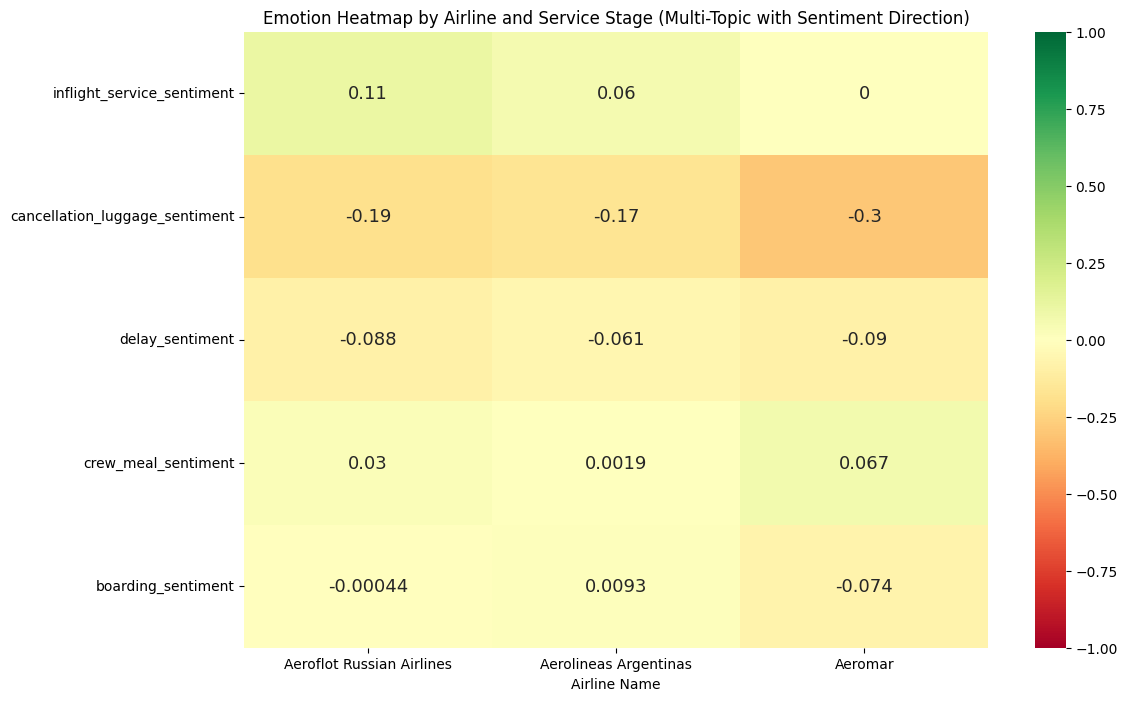

In [36]:
# # heatmap_data = emotion_map.set_index('Airline Name')
# plt.figure(figsize=(12, 8), facecolor='None')
# sns.heatmap(heatmap_data.iloc[:,12:15], annot=True, cmap='RdYlGn', center=0, vmin=-1, vmax=1, annot_kws={"size": 13})
# # plt.title("Emotion Heatmap by Airline and Service Stage (Multi-Topic with Sentiment Direction)")
# plt.show()


In [ ]:
# emotion_map.to_csv('emotion_map_by_airline_and_service_stage.csv', index=False)